In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

from os.path import join

from scipy.stats import fligner, t
from nilearn import plotting, datasets, surface

In [39]:
morph_pal = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(n_colors=5, start=1.8, rot=-0.8, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=5, start=1.8, rot=-0.8, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(n_colors=3, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=3, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
big_pal = morph_pal + cell_pal + func_pal

In [3]:
sns.set(style="white", 
        context="talk", 
        font_scale=0.8,
        rc={"axes.facecolor": (0, 0, 0, 0),
            "font.monospace": 'Courier New',
            "font.family": 'monospace'})
crayons = sns.crayon_palette(['Aquamarine', 'Burnt Sienna', 'Jungle Green', 'Fuchsia', 'Lavender'])

In [4]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [5]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data.csv"), index_col=0, header=0)

In [6]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [7]:

deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
fmri_var = img_modalities['fmri'].columns
fmri_cor_var = img_modalities['fmri'].filter(regex='_c.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns
#morph = img_modalities['smri'].filter(regex='.*vol.*').columns

In [8]:
imaging_apd = list(deltasmri_complete.columns) + list(deltadti_complete.columns) + list(deltarsi_complete.columns) + list(deltarsfmri_complete.columns)

In [9]:
concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd', 
                     'dtifa', 
                     'dtimd'],
            'func':['var',
                    'c',
                    'cor']}

In [10]:
# need to calculate mean & sd for each imaging variable change score
descriptives = pd.DataFrame(columns=['annualized percent change', 'sdev', 'concept', 'atlas', 'measure'])
for var in imaging_apd:
    descriptives.at[var,'annualized percent change'] = df[var].mean()
    descriptives.at[var,'sdev'] = df[var].std()
    if 'mrisdp' in var:
        var_num = int(var.split('.')[0].split('_')[-1])
        descriptives.at[var, 'atlas'] = 'dtx'
        if var_num <= 148:
            descriptives.at[var, 'concept'] = 'morphology'
            descriptives.at[var, 'measure'] = 'thick'
        elif var_num <= 450 and var_num >= 303:
            descriptives.at[var, 'concept'] = 'morphology'
            descriptives.at[var, 'measure'] = 'area'
        elif var_num < 604 and var_num >= 450:
            descriptives.at[var, 'concept'] = 'morphology'
            descriptives.at[var, 'measure'] = 'vol'
        elif var_num <= 1054 and var_num >= 907:
            descriptives.at[var, 'concept'] = 'cellular architecture'
            descriptives.at[var, 'measure'] = 't1wcnt'
        elif var_num == 604:
            descriptives.at[var, 'concept'] = 'morphology'
            descriptives.at[var, 'measure'] = 'vol'
    elif '_' in var:
        var_list = var.split('.')[0].split('_')
        descriptives.at[var, 'measure'] = var_list[1]
        descriptives.at[var, 'atlas'] = var_list[2]
        if var_list[1] in concepts['morph']:
            descriptives.at[var, 'concept'] = 'morphology'
        elif var_list[1] in concepts['cell']:
            descriptives.at[var, 'concept'] = 'cellular architecture'
        if var_list[1] in concepts['func']:
            if var_list[1] == 'c':
                if 
            descriptives.at[var, 'concept'] = 'function'

In [11]:
measures = list(descriptives['measure'].unique())
concepts = ['morphology', 'cellular architecture', 'function']

In [12]:
long_names = {'var': 'BOLD',
              'c': 'FC (c)',
              'cor': 'FC (sc)',
              'dtivol': 'WMV',
              'vol': 'GMV',
              'thick': 'CT',
              'area': 'CA',
              'dtifa': 'FA',
              'dtimd': 'MD',
              'rsirni': 'RNI',
              'rsirnd': 'RND',
              't1wcnt': 'G/W'}

In [13]:
sub_df = descriptives[descriptives['concept'] == 'morphology']
sub2_df = descriptives[descriptives['concept'] == 'cellular architecture']
sub_df = pd.concat([sub_df, sub2_df])
sub_df.replace(long_names, inplace=True)

In [14]:
morph_cell_pal = morph_pal + cell_pal

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


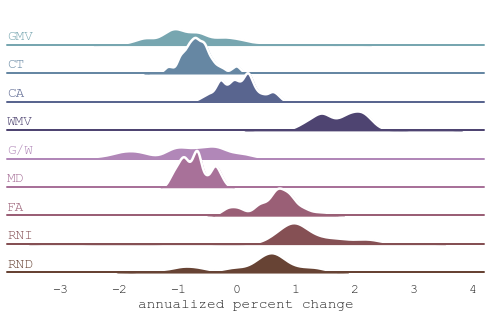

In [15]:
g = sns.FacetGrid(sub_df, 
                  row="measure", row_order=['GMV', 'CT', 'CA', 'WMV', 
                                            'G/W', 'MD', 'FA','RNI', 'RND'],
                  hue="measure", hue_order=['GMV', 'CT', 'CA', 'WMV', 
                                            'G/W', 'MD', 'FA','RNI', 'RND'],
                  aspect=15, height=.5, palette=morph_cell_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "annualized percent change",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "annualized percent change", clip_on=False, color="w", lw=2.5, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "annualized percent change")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/apr_morpcell.png', dpi=400)

In [16]:
sub_df = descriptives[descriptives['concept'] == 'function']
sub_df.replace(long_names, inplace=True)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


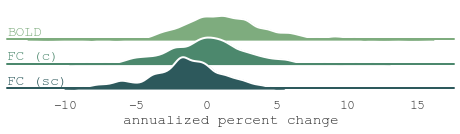

In [20]:
g = sns.FacetGrid(sub_df, row="measure", hue="measure", aspect=16, height=.5, palette=func_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "annualized percent change",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "annualized percent change", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "annualized percent change")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/apr_function.png', dpi=400)

In [35]:
desc_summ = pd.DataFrame(index=measures, columns=['mean', 'sdev', '95%CI'])
for measure in measures:
    temp_df = descriptives[descriptives['measure'] == measure]
    mean = np.mean(temp_df['annualized percent change'])
    desc_summ.at[measure, 'mean'] = np.round(mean,2)
    sdev = np.mean(temp_df['sdev'])
    desc_summ.at[measure, 'sdev'] = np.round(sdev,2)
    dof = len(temp_df.index)-1 
    confidence = 0.95
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    CI = (np.round(mean - sdev *t_crit / np.sqrt(dof + 1), 2), np.round(mean + sdev * t_crit / np.sqrt(dof + 1),2)) 
    desc_summ.at[measure, '95%CI'] = CI

In [36]:
desc_summ

,mean,sdev,95%CI
vol,-0.69,3.69,"(-1.16, -0.23)"
area,0.04,3.38,"(-0.41, 0.49)"
thick,-0.66,2.12,"(-0.95, -0.38)"
t1wcnt,-0.94,4.49,"(-1.55, -0.34)"
dtifa,0.65,2.61,"(-0.22, 1.52)"
dtimd,-0.71,2.06,"(-1.39, -0.02)"
dtivol,1.8,3.2,"(0.73, 2.86)"
rsirni,1.14,2.54,"(0.49, 1.78)"
rsirnd,0.28,2.89,"(-0.47, 1.03)"
var,1.41,25.76,"(-1.06, 3.88)"


In [40]:
df.min()

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_28182/3962516015.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.min()


imgincl_dmri_include.baseline_year_1_arm_1             0.0
imgincl_dmri_include.2_year_follow_up_y_arm_1          0.0
imgincl_rsfmri_include.baseline_year_1_arm_1           0.0
imgincl_rsfmri_include.2_year_follow_up_y_arm_1        0.0
imgincl_t1w_include.baseline_year_1_arm_1              0.0
                                                      ... 
demo_comb_income_v2.2_year_follow_up_y_arm_1           NaN
pds_p_ss_female_category_2.baseline_year_1_arm_1       1.0
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1    1.0
pds_p_ss_male_category_2.baseline_year_1_arm_1         1.0
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1      1.0
Length: 6139, dtype: object

In [ ]:
# let's visualize APD!
destrieux = datasets.fetch_atlas_destrieux_2009()
desikan = datasets.fetch_neurovault_ids(image_ids=(23262, ))
subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')

In [ ]:
# list of measures to plot
measures = {'cortical-thickness': 'smri_thick_cdk_*',
            'cortical-area': 'smri_area_cdk_.*',
            'cortical-volume': 'smri_vol_cdk_.*', 
            'subcortical-volume': 'smri_vol_scs_.*', 
            'subcortical-RND': 'dmri_rsirnd_scs_.*',
            'subcortical-RNI': 'dmri_rsirni_scs_.*',
            'tract-volume': 'dmri_dtivol_fiberat_.*', 
            'tract-FA': 'dmri_dtifa_fiberat_.*', 
            'tract-MD': 'dmri_dtimd_fiberat_.*', 
            'tract-RND': 'dmri_rsirnd_fib_.*',
            'tract-RNI': 'dmri_rsirni_fib_.*'}
vmax = 60
cmap = 'viridis'

conn_measures = {'cortical-network-connectivity': 'rsfmri_c_ngd_.*',
            'subcortical-network-connectivity': 'rsfmri_cor_ngd_.*_scs_.*',}

In [ ]:
for measure in measures:
    print(measure)
    meas_df = df.filter(regex=measures[measure], axis=0)
    print(len(meas_df.index))
    min_apr = meas_df.min()
    max_apr = meas_df.max()
    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

    cb = mpl.colorbar.ColorbarBase(ax, 
                                   orientation='horizontal', 
                                   cmap=cmap, 
                                   values=range(min_apr, max_apr))

    plt.savefig(f'../figures/{measure}_{cmap}_{min_apr}-{max_apr}.png', bbox_inches='tight', dpi=400)
    meas_vars = [i.split('.')[0] for i in meas_df.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in meas_df.index:
        if 'cdk_total' in i:
            pass
        else:
            j = i.split('.')[0]
            value = nifti_mapping.loc[j]['atlas_value']
            #print(i, value)
            if value is np.nan:
                pass
            else:
                if var_df.at[i,(fligner_var, 'a<0.05')] == '**':
                    sig += 1
                    plotting_arr[np.where(atlas_arr == value)] = var_df.at[i,(fligner_var, 'stat')]
                else:
                    plotting_arr[np.where(atlas_arr == value)] = 0
    print('plotting...', f'{sig} out of {len(meas_df.index)} heteroskedastic regions')
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    if 'subcortical' in measure:
        grid_kw = dict(width_ratios=[3,1])
        plt.figure(layout='tight')
        fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
        q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=1,
                               cut_coords=[-20, -10, 0, 10], vmax=vmax, 
                               annotate=False, cmap=cmap, colorbar=False,
                               symmetric_cbar=False, axes=ax[0])

        ax[1].set_visible(False)
        q.savefig(f'../figures/{measure}x{fligner}_fk_scs.png', dpi=400)
    elif 'tract' in measure:
        fibers = nifti_mapping.filter(regex=measures[measure], axis=0).index
        var = fibers[0]
        tract_fname = nifti_mapping.loc[var]['atlas_fname']
        tract_nii = nib.load(tract_fname)
        tract_arr = tract_nii.get_fdata()
        #print(np.unique(tract_arr))
        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
        all_tracts_arr = np.zeros(tract_arr.shape)
        all_tracts_arr += tract_arr
        for var in fibers[1:]:    
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            if type(tract_fname) is str:
                try:
                    tract_nii = nib.load(tract_fname)
                    tract_arr = tract_nii.get_fdata()
                    print(np.unique(tract_arr))
                    if var_df.at[f'{var}.change_score',(fligner_var, 'a<0.05')] == '**':
                        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
                    else:
                        tract_arr *= 0
                    all_tracts_arr += tract_arr
                except Exception as e:
                    pass
            else:
                pass
        meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
        plt.figure(layout='tight')
        #fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
        q = plotting.plot_anat(meas_nimg, display_mode='z',  threshold=1,
                               cut_coords=[35,50,65,85], 
                               black_bg=False,
                                   vmax=vmax, 
                                   annotate=False, cmap=cmap, colorbar=False,
                                   #axes=ax[0]
                              )
        #ax[1].set_visible(False)
        q.savefig(f'../figures/{measure}x{fligner}_fk_tract.png', dpi=400)
    elif 'cortical' in measure:
        texture_l = surface.vol_to_surf(meas_nimg, fsaverage.pial_left, interpolation='nearest')
        texture_r = surface.vol_to_surf(meas_nimg, fsaverage.pial_right, interpolation='nearest')

        figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                             cmap=cmap, view='medial', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        figure.savefig(f'../figures/{measure}x{fligner}_fk_leftmed.png', dpi=400)
        figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                             cmap=cmap, view='lateral', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        figure.savefig(f'../figures/{measure}x{fligner}_fk_leftlat.png', dpi=400)
        figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                             cmap=cmap, view='medial', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        figure.savefig(f'../figures/{measure}x{fligner}_fk_rightlat.png', dpi=400)
        figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                             cmap=cmap, view='lateral', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        figure.savefig(f'../figures/{measure}x{fligner}_fk_rightmed.png', dpi=400)